In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ALS').getOrCreate()

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import lit

In [4]:
def loadMovieNames():
    movieNames = {}
    with open('u.item',encoding='ISO-8859-1') as f:
        for lines in f:
            fields = lines.split('|')
            movieNames[int(fields[0])]=fields[1]
    return movieNames

In [5]:
movie_Names = loadMovieNames()

In [6]:
movie_Names

{1: 'Toy Story (1995)',
 2: 'GoldenEye (1995)',
 3: 'Four Rooms (1995)',
 4: 'Get Shorty (1995)',
 5: 'Copycat (1995)',
 6: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 7: 'Twelve Monkeys (1995)',
 8: 'Babe (1995)',
 9: 'Dead Man Walking (1995)',
 10: 'Richard III (1995)',
 11: 'Seven (Se7en) (1995)',
 12: 'Usual Suspects, The (1995)',
 13: 'Mighty Aphrodite (1995)',
 14: 'Postino, Il (1994)',
 15: "Mr. Holland's Opus (1995)",
 16: 'French Twist (Gazon maudit) (1995)',
 17: 'From Dusk Till Dawn (1996)',
 18: 'White Balloon, The (1995)',
 19: "Antonia's Line (1995)",
 20: 'Angels and Insects (1995)',
 21: 'Muppet Treasure Island (1996)',
 22: 'Braveheart (1995)',
 23: 'Taxi Driver (1976)',
 24: 'Rumble in the Bronx (1995)',
 25: 'Birdcage, The (1996)',
 26: 'Brothers McMullen, The (1995)',
 27: 'Bad Boys (1995)',
 28: 'Apollo 13 (1995)',
 29: 'Batman Forever (1995)',
 30: 'Belle de jour (1967)',
 31: 'Crimson Tide (1995)',
 32: 'Crumb (1994)',
 33: 'Desperado (1995)',
 34: '

In [7]:
lines = spark.sparkContext.textFile('u.data')

In [8]:
lines

u.data MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [9]:
# def parseInput(line):
#     fields = line.split()
#     return Row(movieID = int(fields[1]), rating = float(fields[2]))

In [10]:
def parseInput(line):
    fields = line.split()
    return Row(userID = int(fields[0]),movieID=int(fields[1]),rating=float(fields[2]))

In [11]:
movieRatings = lines.map(parseInput)

In [12]:
movieRatings.take(10)

[Row(movieID=50, rating=5.0, userID=0),
 Row(movieID=172, rating=5.0, userID=0),
 Row(movieID=133, rating=1.0, userID=0),
 Row(movieID=242, rating=3.0, userID=196),
 Row(movieID=302, rating=3.0, userID=186),
 Row(movieID=377, rating=1.0, userID=22),
 Row(movieID=51, rating=2.0, userID=244),
 Row(movieID=346, rating=1.0, userID=166),
 Row(movieID=474, rating=4.0, userID=298),
 Row(movieID=265, rating=2.0, userID=115)]

In [13]:
ratings = spark.createDataFrame(movieRatings).cache()

In [14]:
als = ALS(maxIter=5, regParam=0.01, userCol="userID", itemCol="movieID", ratingCol="rating")

In [1]:
## Parameters and Hyperparameters

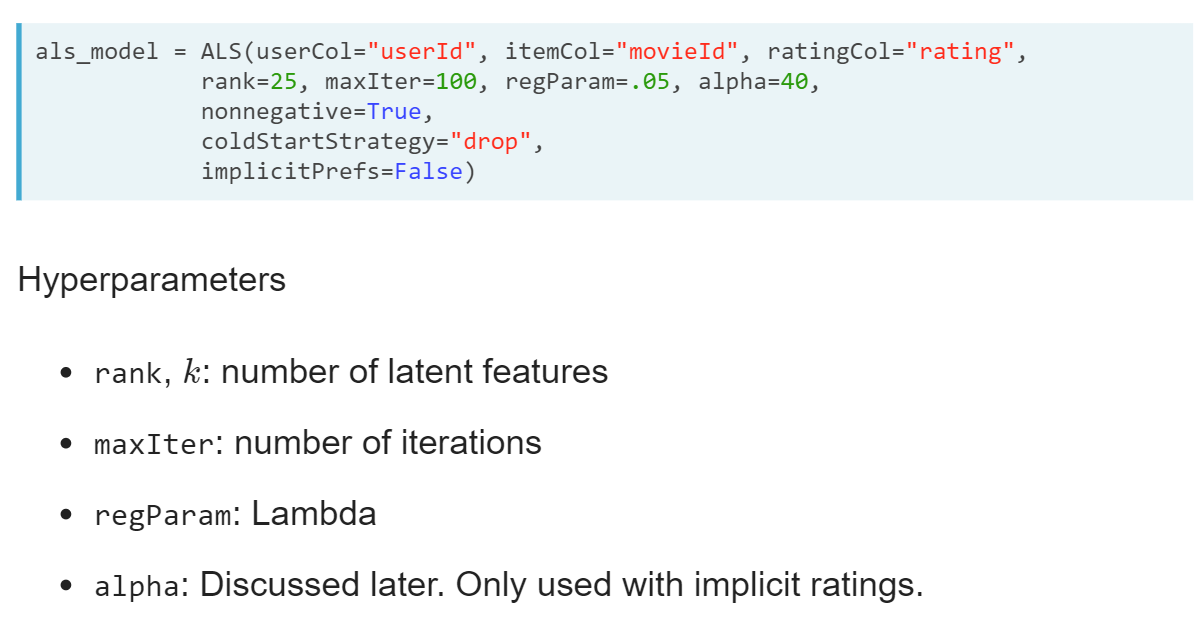

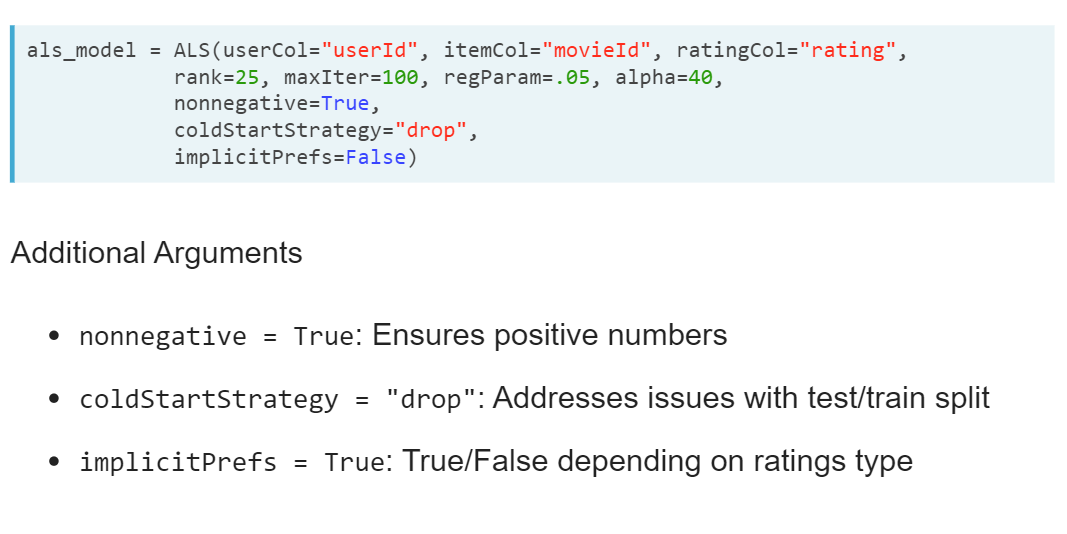

In [15]:
model = als.fit(ratings)

In [16]:
ratings.head(10)

[Row(movieID=50, rating=5.0, userID=0),
 Row(movieID=172, rating=5.0, userID=0),
 Row(movieID=133, rating=1.0, userID=0),
 Row(movieID=242, rating=3.0, userID=196),
 Row(movieID=302, rating=3.0, userID=186),
 Row(movieID=377, rating=1.0, userID=22),
 Row(movieID=51, rating=2.0, userID=244),
 Row(movieID=346, rating=1.0, userID=166),
 Row(movieID=474, rating=4.0, userID=298),
 Row(movieID=265, rating=2.0, userID=115)]

In [17]:
ratings_df = ratings.groupBy('movieID').count().filter('count>100')

In [18]:
ratings_df.describe().show()

+-------+-----------------+------------------+
|summary|          movieID|             count|
+-------+-----------------+------------------+
|  count|              334|               334|
|   mean|316.7694610778443|192.88023952095807|
| stddev|222.8370123646172| 86.44592834407987|
|    min|                1|               101|
|    max|             1047|               584|
+-------+-----------------+------------------+



In [19]:
# Construct a "test" dataframe for user 0 with every movie rated more than 100 times
popularMovies = ratings_df.select("movieID").withColumn('userID', lit(0))

In [20]:
popularMovies.head(10)

[Row(movieID=474, userID=0),
 Row(movieID=29, userID=0),
 Row(movieID=65, userID=0),
 Row(movieID=191, userID=0),
 Row(movieID=418, userID=0),
 Row(movieID=222, userID=0),
 Row(movieID=293, userID=0),
 Row(movieID=270, userID=0),
 Row(movieID=367, userID=0),
 Row(movieID=705, userID=0)]

In [21]:
popularMovies.describe().show()

+-------+-----------------+------+
|summary|          movieID|userID|
+-------+-----------------+------+
|  count|              334|   334|
|   mean|316.7694610778443|   0.0|
| stddev|222.8370123646172|   0.0|
|    min|                1|     0|
|    max|             1047|     0|
+-------+-----------------+------+



In [22]:
# Run our model on that list of popular movies for user ID 0
recommendations = model.transform(popularMovies)

In [23]:
recommendations.head(10)

[Row(movieID=148, userID=0, prediction=2.639016628265381),
 Row(movieID=471, userID=0, prediction=2.9520201683044434),
 Row(movieID=496, userID=0, prediction=2.2276227474212646),
 Row(movieID=243, userID=0, prediction=2.031177282333374),
 Row(movieID=31, userID=0, prediction=3.336245059967041),
 Row(movieID=137, userID=0, prediction=3.2108185291290283),
 Row(movieID=451, userID=0, prediction=2.1252238750457764),
 Row(movieID=65, userID=0, prediction=1.699249505996704),
 Row(movieID=879, userID=0, prediction=2.91396427154541),
 Row(movieID=53, userID=0, prediction=3.9181571006774902)]

In [24]:
topRecommendations = recommendations.sort(recommendations.prediction.desc()).take(20)

In [25]:
for movie in topRecommendations:
    print(movie_Names[movie[0]],movie[2])

Star Trek: The Wrath of Khan (1982) 5.322769641876221
Terminator, The (1984) 5.285007476806641
Army of Darkness (1993) 5.282867908477783
Rumble in the Bronx (1995) 5.268683910369873
Conan the Barbarian (1981) 5.197256088256836
Star Wars (1977) 5.010411739349365
Empire Strikes Back, The (1980) 4.93565559387207
Jackie Chan's First Strike (1996) 4.905279636383057
Terminator 2: Judgment Day (1991) 4.8677449226379395
Blade Runner (1982) 4.846139430999756
Tombstone (1993) 4.833973407745361
Star Trek VI: The Undiscovered Country (1991) 4.77596378326416
Return of the Jedi (1983) 4.748522758483887
Alien (1979) 4.743969440460205
Good, The Bad and The Ugly, The (1966) 4.734192848205566
Wrong Trousers, The (1993) 4.733634948730469
Raiders of the Lost Ark (1981) 4.709850311279297
Con Air (1997) 4.686665058135986
Mystery Science Theater 3000: The Movie (1996) 4.662295341491699
Star Trek IV: The Voyage Home (1986) 4.560464859008789
